<a href="https://colab.research.google.com/github/bj-noh/lecture_nlp/blob/master/src/example/torch_hub_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
# MNIST 데이터셋 로드
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15943520.54it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 535993.90it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3817094.18it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10954875.66it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# 사전 학습된 VGG16 모델 불러오기
model_vgg16 = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 168MB/s]


In [5]:
# 모델의 마지막 레이어 수정
num_features = model_vgg16.classifier[6].in_features
model_vgg16.classifier[6] = nn.Sequential(
    nn.Linear(num_features, 4096),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(4096, 1000),
    nn.ReLU(),
    nn.Linear(1000, 10),
    nn.LogSoftmax(dim=1)
)

In [6]:
# 모든 레이어를 고정 (학습되지 않도록 설정)
for param in model_vgg16.features.parameters():
    param.requires_grad = False

In [7]:
# GPU 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_vgg16 = model_vgg16.to(device)

In [8]:
# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vgg16.classifier.parameters(), lr=0.001)

In [9]:
# 모델 훈련
num_epochs = 10
for epoch in range(num_epochs):
    model_vgg16.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_vgg16(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

Epoch 1/10, Loss: 0.7201, Accuracy: 77.06%
Epoch 2/10, Loss: 0.4575, Accuracy: 86.81%
Epoch 3/10, Loss: 0.3783, Accuracy: 89.23%
Epoch 4/10, Loss: 0.3687, Accuracy: 89.74%
Epoch 5/10, Loss: 0.3396, Accuracy: 90.41%
Epoch 6/10, Loss: 0.3202, Accuracy: 90.95%
Epoch 7/10, Loss: 0.3126, Accuracy: 91.18%
Epoch 8/10, Loss: 0.3021, Accuracy: 91.53%
Epoch 9/10, Loss: 0.2942, Accuracy: 91.76%
Epoch 10/10, Loss: 0.2965, Accuracy: 91.80%


In [10]:
# 모델 평가
model_vgg16.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total}%")

Test Accuracy: 94.49%


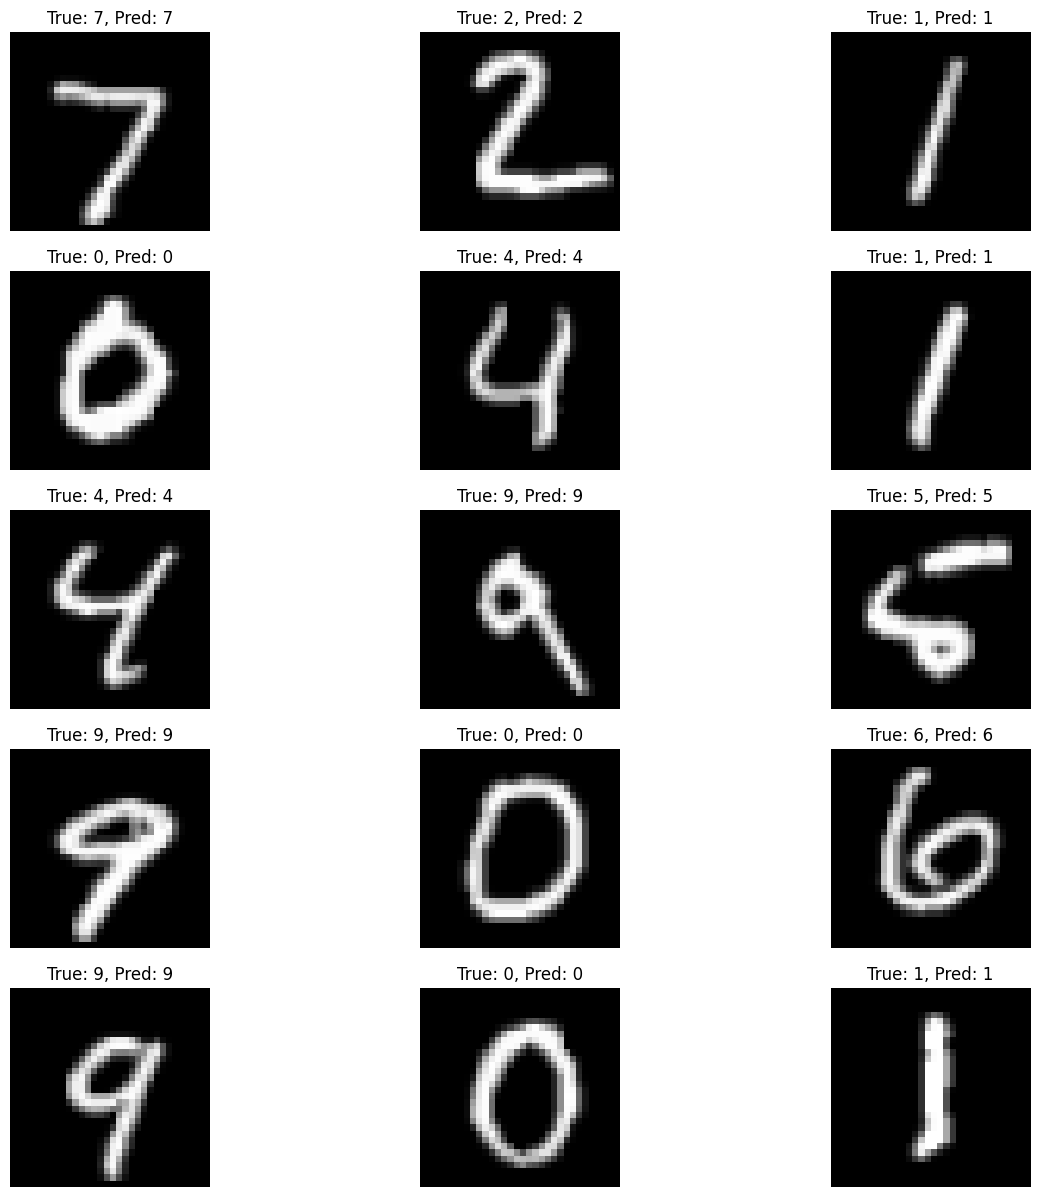

In [12]:
# 예시 이미지 시각화
examples = iter(test_loader)
example_data, example_labels = next(examples)

with torch.no_grad():
    example_data = example_data.to(device)
    output = model_vgg16(example_data)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(15, 15))
for i in range(15):
    plt.subplot(5, 3, i + 1)
    plt.imshow(example_data[i].cpu().permute(1, 2, 0) * 0.5 + 0.5)
    plt.title(f"True: {example_labels[i]}, Pred: {preds[i].item()}")
    plt.axis('off')
plt.show()